In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))

32033


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),    generator=g)   * (5/3) / ((n_embd * block_size)**0.5)
W2 = torch.randn((n_hidden, vocab_size),             generator=g)   * 0.01
b2 = torch.randn(vocab_size,                         generator=g)   * 0

#batchNorm Params
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] 
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [12]:
max_steps = 200000
batch_size = 32
lossi = []
eps = 1e-5

for i in range(max_steps):
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    #linear layer
    hpreact = embcat @ W1

    #batchnorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + eps) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    #non - linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.0288
  10000/ 200000: 2.3032
  20000/ 200000: 2.2280
  30000/ 200000: 1.9055
  40000/ 200000: 2.3323
  50000/ 200000: 1.7543
  60000/ 200000: 2.2944
  70000/ 200000: 2.2099
  80000/ 200000: 1.9345
  90000/ 200000: 2.1167
 100000/ 200000: 2.1284
 110000/ 200000: 2.0392
 120000/ 200000: 2.4743
 130000/ 200000: 2.0502
 140000/ 200000: 1.9178
 150000/ 200000: 1.7128
 160000/ 200000: 1.8889
 170000/ 200000: 2.2147
 180000/ 200000: 1.7213
 190000/ 200000: 2.2175


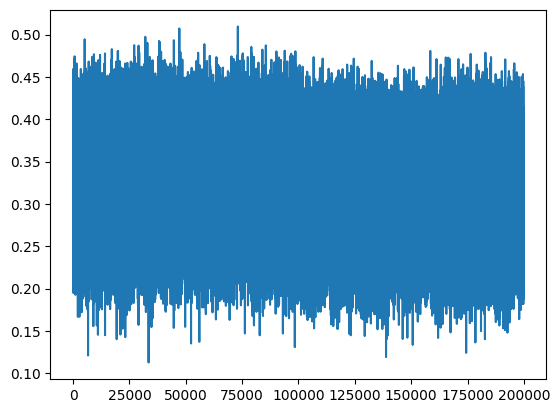

In [13]:
plt.plot(lossi)

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0510761737823486
val 2.0987465381622314


In [16]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

cathlizabbillpkfisrishristyviahfyansja.
bnixfarwyyrt.
kaedix.
quinithziriavivanekyah.
blgistutefflnishlistan.
vabbigabriff.
jarixexfknessirstimesticoishgttsleynardhamaskmisrissyahshmariozswuf.
jesvalairahnakaylahnn.
mazobbertsramsryahramskemtrryah.
xeinaodusly.
blds.
truquintonbesphrudrprissslytte.
conzahmmyghn.
khlbsesdan.
kzamdyev.
bly.
qoyyah.
rowk.
kaimkoiorgracielsinszesmanxellistimercsslytth.
yobadyselisabbigryffiyohnm.
